In [2]:
from attack_predictor_libs.dataset.guide_dataset import GuideDataset
import polars as pl
from attack_predictor_libs.visualize.scenario_visualizer import visualize_scenario
from tqdm import tqdm

## 仮説検証内容
仮説：攻撃は、Preparation, Intrusion, Compromiseのこの３つの順番に処理が進んでいる。
この仮説が正しいか検証する。  

### 仮説検証 (Trainデータ)

In [3]:
dataset = GuideDataset()

In [31]:
df_polars = dataset.data.filter(pl.col("IncidentGrade") == "TruePositive").sort("Timestamp")

In [32]:
df = df_polars.to_pandas()

In [33]:
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,SuspicionLevel,LastVerdict,CountryCode,State,City,dataset_type,is_preparation_alert,is_intrusion_alert,is_compromise_alert,alert_bit_value
0,111669151346,1033,104748,915835,2023-12-08 12:34:50,0,0,InitialAccess,T1078;T1078.004,TruePositive,...,None,None,0,22,41,train,True,True,False,3
1,111669151346,1033,104748,915835,2023-12-08 12:34:50,0,0,InitialAccess,T1078;T1078.004,TruePositive,...,None,None,242,1445,10630,train,True,True,False,3
2,111669151346,1033,104748,915835,2023-12-08 12:34:50,0,0,InitialAccess,T1078;T1078.004,TruePositive,...,None,None,242,1445,10630,train,True,True,False,3
3,111669151346,1033,104748,915835,2023-12-08 12:34:50,0,0,InitialAccess,T1078;T1078.004,TruePositive,...,None,None,242,1445,10630,train,True,True,False,3
4,764504182313,647,385384,1045452,2023-12-08 13:00:32,0,0,InitialAccess,T1078;T1078.004,TruePositive,...,None,None,242,1445,10630,train,True,True,False,3


In [60]:
keys = ["dataset_type", "OrgId", "IncidentId"]
total_counts = df.groupby(keys).size()
mask = df["MitreTechniques"].astype(str).str.contains("T1078",case=True, regex=False, na=False)
cond_counts =  df[mask].groupby(keys).size()
cond_counts = cond_counts.reindex(total_counts.index, fill_value=0)

In [61]:
rel_freq = (cond_counts/total_counts).to_frame()

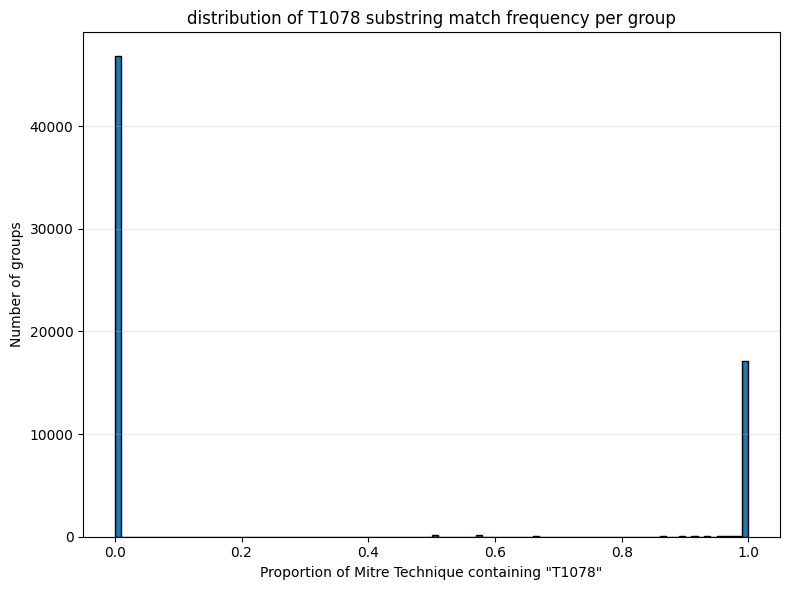

In [62]:
import matplotlib.pyplot as plt
figsize = (8,6)
title =  "distribution of T1078 substring match frequency per group"
bins = 100

plt.figure(figsize=figsize)
n, bin_edges, patches = plt.hist(rel_freq, bins=bins, edgecolor='black')
plt.xlabel(f'Proportion of Mitre Technique containing "T1078"')
plt.ylabel('Number of groups')
if title is None:
    if isinstance(keys, (list, tuple)):
        key_str = ', '.join(keys)
    else:
        key_str = str(keys)
    title = f'Distribution of substring match frequency per group [{key_str}]'
plt.title(title)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [64]:
# ① マスクを用意
high_freq = rel_freq[ rel_freq >= 0.9 ]

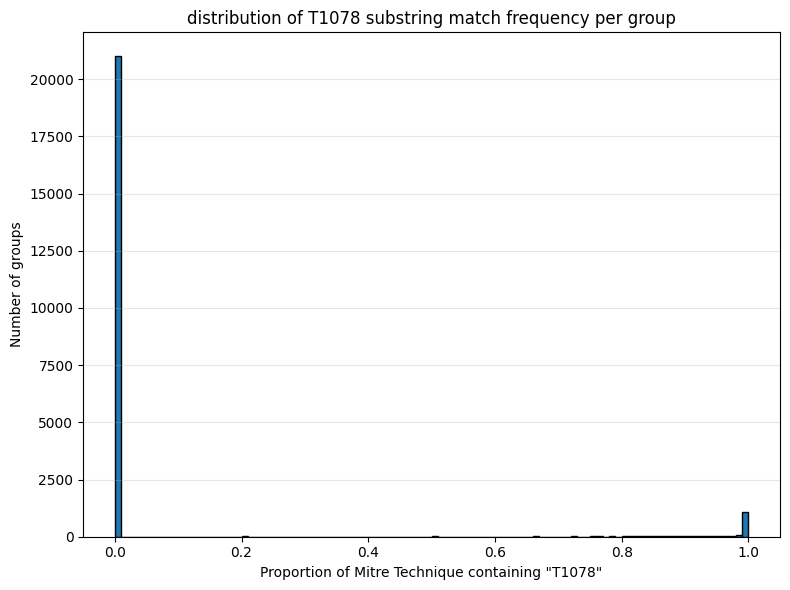

In [ ]:
import matplotlib.pyplot as plt
figsize = (8,6)
title =  "distribution of T1078 substring match frequency per group"
bins = 100

plt.figure(figsize=figsize)
n, bin_edges, patches = plt.hist(high_freq, bins=bins, edgecolor='black')
plt.xlabel(f'Proportion of Mitre Technique containing "T1078"')
plt.ylabel('Number of groups')
if title is None:
    if isinstance(keys, (list, tuple)):
        key_str = ', '.join(keys)
    else:
        key_str = str(keys)
    title = f'Distribution of substring match frequency per group [{key_str}]'
plt.title(title)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
cdf.get_column("is_compromise_alert").sum()

281

In [13]:
cdf.shape

(45535, 4)

In [21]:
ret_dict = {}
gdf = df.group_by(["OrgId","IncidentId"])

for key, group_df in tqdm(gdf, total=df.n_unique(subset=["OrgId","IncidentId"])):
    
    tmpdf = group_df.with_columns(
        pl.max_horizontal(
            pl.col("is_preparation_alert").cast(int),
            pl.col("is_intrusion_alert").cast(int)*2,
            pl.col("is_compromise_alert").cast(int)*4
        ).alias("phase"),
    ).sort("Timestamp")

    min_value = tmpdf.select(
        pl.col("phase").diff().fill_null(0).alias("phase_diff")
    ).get_column("phase_diff").min()
    
    # keyはincident_id, min_valueはマイナスであれば、Preparation, Intrusino, Compromiseの順でアラートが来て以内ということを示す。
    ret_dict[str(key[0]) + "_" + str(key[1])] = min_value

100%|██████████| 45535/45535 [02:18<00:00, 329.31it/s]


In [35]:
incident_df = df.group_by(["OrgId", "IncidentId"]).agg([pl.col("is_preparation_alert").any(), pl.col("is_intrusion_alert").any(), pl.col("is_compromise_alert").any()])
incident_df =  incident_df.with_columns(    (
            (pl.col("is_preparation_alert").cast(int) *(2**0)) +  # is_preparation_alert をビット2にシフト
            (pl.col("is_intrusion_alert").cast(int) *(2**1)) +   # is_intrusion_alert をビット1にシフト
            pl.col("is_compromise_alert").cast(int)  *(2**2)           # is_compromise_alert をビット0に
    ).alias("alert_bit_value"))

In [36]:
incident_df = incident_df.join(cdf, on = ["OrgId", "IncidentId"])

In [39]:
incident_df = incident_df.with_columns((pl.col("OrgId").cast(str) + "_" + pl.col("IncidentId").cast(str)).replace_strict(ret_dict).cast(int).alias("ret_value"))
not_expected_scenario_dict = {}
for key, group_df in incident_df.group_by(["OrgId", "IncidentId"]):
    key = str(key[0]) + "_" + str(key[1])
    count = group_df.filter(pl.col("ret_value") < 0).shape[0]
    not_expected_scenario_dict[key] = count
    # if count > 0:
        # print(key)

In [47]:
incident_df = incident_df.with_columns((pl.col("OrgId").cast(str) + "_" + pl.col("IncidentId").cast(str)).alias("ID"))

In [49]:
incident_df.head()

OrgId,IncidentId,is_preparation_alert,is_intrusion_alert,is_compromise_alert,alert_bit_value,dataset_type,is_compromise_alert_right,ret_value,ID
i64,i64,bool,bool,bool,i64,str,bool,i64,str
38,289739,true,true,false,3,"""train""",false,0,"""38_289739"""
38,456186,true,true,false,3,"""train""",false,0,"""38_456186"""
195,29503,true,true,false,3,"""train""",false,0,"""195_29503"""
107,26627,true,false,false,1,"""train""",false,0,"""107_26627"""
38,457719,true,true,false,3,"""train""",false,0,"""38_457719"""


In [53]:
incident_df.group_by("alert_bit_value").agg(pl.col("is_compromise_alert_right").sum()).sort("alert_bit_value")
# .with_columns(pl.col("ID").replace_strict(not_expected_scenario_dict).alias("not_expected_scenario_count"))

alert_bit_value,is_compromise_alert_right
i64,u32
0,0
1,0
2,0
3,0
4,199
5,0
6,79
7,3


In [ ]:
incident_df.filter( pl.col("alert_bit_value")==7).with_columns( (pl.col("OrgId").cast(str) + "_" + pl.col("IncidentId").cast(str))).get_column("OrgId").to_list()

### 仮説検証 (Testデータ)

In [55]:
test_df  = dataset.data.filter(pl.col("dataset_type") == 'test').filter(pl.col("IncidentGrade") == "TruePositive").sort("Timestamp")

In [56]:
cdf = test_df.group_by(["OrgId", "IncidentId"]).agg(pl.col("is_compromise_alert").first())

In [57]:
test_df = test_df.join(cdf, on = ["OrgId", "IncidentId"])

In [58]:
ret_dict = {}
gdf = test_df.group_by(["OrgId","IncidentId"])

for key, group_df in tqdm(gdf, total=test_df.n_unique(subset=["OrgId","IncidentId"])):
    
    tmpdf = group_df.with_columns(
        pl.max_horizontal(
            pl.col("is_preparation_alert").cast(int),
            pl.col("is_intrusion_alert").cast(int)*2,
            pl.col("is_compromise_alert").cast(int)*4
        ).alias("phase"),
    ).sort("Timestamp")

    min_value = tmpdf.select(
        pl.col("phase").diff().fill_null(0).alias("phase_diff")
    ).get_column("phase_diff").min()
    
    # keyはincident_id, min_valueはマイナスであれば、Preparation, Intrusino, Compromiseの順でアラートが来て以内ということを示す。
    ret_dict[str(key[0]) + "_" + str(key[1])] = min_value

100%|██████████| 19613/19613 [01:01<00:00, 320.75it/s]


In [59]:
incident_df = test_df.group_by(["OrgId", "IncidentId"]).agg([pl.col("is_preparation_alert").any(), pl.col("is_intrusion_alert").any(), pl.col("is_compromise_alert").any()])
# incident_df = test_df.group_by("IncidentId").agg([pl.col("is_preparation_alert").any(), pl.col("is_intrusion_alert").any(), pl.col("is_compromise_alert").any()])
incident_df =  incident_df.with_columns(    (
            (pl.col("is_preparation_alert").cast(int) *(2**0)) +  # is_preparation_alert をビット2にシフト
            (pl.col("is_intrusion_alert").cast(int) *(2**1)) +   # is_intrusion_alert をビット1にシフト
            pl.col("is_compromise_alert").cast(int)  *(2**2)           # is_compromise_alert をビット0に
    ).alias("alert_bit_value")
)

In [60]:
incident_df = incident_df.with_columns((pl.col("OrgId").cast(str) + "_" + pl.col("IncidentId").cast(str)).replace_strict(ret_dict).cast(int).alias("ret_value"))
not_expected_scenario_dict = {}
for key, group_df in incident_df.group_by("alert_bit_value"):
    key = key[0]
    count = group_df.filter(pl.col("ret_value") < 0).shape[0]
    not_expected_scenario_dict[key] = count

In [67]:
incident_df.group_by("alert_bit_value").agg(pl.count("IncidentId").alias("count")).sort("alert_bit_value").with_columns(pl.col("alert_bit_value").replace_strict(not_expected_scenario_dict).alias("not_expected_scenario_count"))

alert_bit_value,count,not_expected_scenario_count
i64,u32,i64
0,19,0
1,11360,0
2,2274,0
3,5835,91
4,86,0
6,36,4
7,3,3


In [65]:
# incident_df = incident_df.join(cdf, on = ["OrgId", "IncidentId"])
incident_df.head()

OrgId,IncidentId,is_preparation_alert,is_intrusion_alert,is_compromise_alert,alert_bit_value,ret_value,is_compromise_alert_right
i64,i64,bool,bool,bool,i64,i64,bool
455,33680,true,false,false,1,0,false
205,39540,true,false,false,1,0,false
216,31246,true,false,false,1,0,false
272,97415,true,false,false,1,0,false
1360,6658,true,false,false,1,0,false


In [68]:
incident_df.group_by("alert_bit_value").agg(pl.col("is_compromise_alert_right").sum()).sort("alert_bit_value")

alert_bit_value,is_compromise_alert_right
i64,u32
0,0
1,0
2,0
3,0
4,86
6,33
7,2


In [53]:
incident_df.filter( pl.col("alert_bit_value")==7).with_columns( (pl.col("OrgId").cast(str) + "_" + pl.col("IncidentId").cast(str))).get_column("OrgId").to_list()

['899_81161', '445_2613', '240_704']

### hogehoge
preparation, intrusion, compromise全てが含まれる７にて、どのような結果になっているか確認する。

In [13]:
df  = dataset.data.filter(pl.col("dataset_type") == 'train').filter(pl.col("IncidentGrade") == "TruePositive")

In [15]:
ret_dict = {}
gdf = df.group_by("IncidentId")
for key, group_df in tqdm(gdf, total=df.n_unique("IncidentId")):
    
    tmpdf = group_df.with_columns(
        pl.max_horizontal(
            pl.col("is_preparation_alert").cast(int),
            pl.col("is_intrusion_alert").cast(int)*2,
            pl.col("is_compromise_alert").cast(int)*4
        ).alias("phase"),
    ).sort("Timestamp")

    min_value = tmpdf.select(
        pl.col("phase").diff().fill_null(0).alias("phase_diff")
    ).get_column("phase_diff").min()
    
    # keyはincident_id, min_valueはマイナスであれば、Preparation, Intrusino, Compromiseの順でアラートが来て以内ということを示す。
    ret_dict[key[0]] = min_value

  0%|          | 0/42701 [00:00<?, ?it/s]

  1%|          | 272/42701 [00:00<02:32, 278.04it/s]


KeyboardInterrupt: 

In [49]:
incident_df = df.group_by("IncidentId").agg([pl.col("is_preparation_alert").any(), pl.col("is_intrusion_alert").any(), pl.col("is_compromise_alert").any()])
incident_df =  incident_df.with_columns(    (
            (pl.col("is_preparation_alert").cast(int) *(2**0)) +  # is_preparation_alert をビット2にシフト
            (pl.col("is_intrusion_alert").cast(int) *(2**1)) +   # is_intrusion_alert をビット1にシフト
            pl.col("is_compromise_alert").cast(int)  *(2**2)           # is_compromise_alert をビット0に
    ).alias("alert_bit_value")
)

In [50]:
incident_df = incident_df.with_columns(
    pl.col("IncidentId").replace_strict(ret_dict).cast(int).alias("ret_value")
)
not_expected_scenario_dict = {}
for key, group_df in incident_df.group_by("alert_bit_value"):
    key = key[0]
    count = group_df.filter(pl.col("ret_value") < 0).shape[0]
    not_expected_scenario_dict[key] = count

In [65]:
incident_df.filter(pl.col("alert_bit_value") == 7).filter(pl.col("ret_value") >= 0)

IncidentId,is_preparation_alert,is_intrusion_alert,is_compromise_alert,alert_bit_value,ret_value
i64,bool,bool,bool,i64,i64
76576,true,true,true,7,0
82346,true,true,true,7,0
22884,true,true,true,7,0
68383,true,true,true,7,0
13658,true,true,true,7,0
…,…,…,…,…,…
18652,true,true,true,7,0
14335,true,true,true,7,0
49860,true,true,true,7,0
